# 8.XGBoost Classifier

*Made by David Serrano for his Final Bachelor Thesis*

This file gets the stored features to classify the tracks using XGBoost. All the resampling techniques explained in the report are used.

## 8.1.Environment Preparation

In [ ]:
# Useful general imports
from google.colab import drive

In [ ]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Add the folder called utils that has all the custom modules in .py files
import sys
sys.path.append('/content/drive/MyDrive/TFG/utils')

In [ ]:
from paths import PROJECT_ROOT, HDF5_FOLDER, JSON_FOLDER, USABLE_SEQUENCES, MAX_SQUARE_LEN

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 8.2.Feature Collecting

In [ ]:
modelName = 'ResNet50_epoch5_dataAug55.pt'
concatenated = True

In [ ]:
import numpy as np

from JSONLoader import loadData
X = []
y = []
for seq in USABLE_SEQUENCES:
    features_i = loadData(PROJECT_ROOT + '/data/Features/concatenatedFeatures/con/' + seq + '.h5.json')
    for feat in features_i:
        X.append(feat[0:-1])
        y.append(feat[-1])

X = np.array(X)
y = np.array(y)

In [ ]:
from torchvision.models import resnet50
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import time
from tqdm.notebook import tqdm

# Custom Imports
from dataPrep import detectionLoader, hdf5Initializer
from dataStructures import Dataset

if not STORAGE:
    # Load the model
    model = resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Linear(128,3)
    )

    model.load_state_dict(torch.load(PROJECT_ROOT + '/models/' + modelName,
                                     map_location=torch.device('cpu')))
    
    # Delete the final two layers of the model (ReLU and Linnear(128,3))
    model.fc = nn.Sequential(*[model.fc[0]])
    print('The fully connected layer of the model is:\n', model.fc)

    # Initialize the hdf5Loaders and create a Dataloader for each sequence

    print('Creating a DataLoader for each sequence file...')
    dataloaders = []
    for idx, seq in enumerate(USABLE_SEQUENCES):
        loaders = [None] * len(USABLE_SEQUENCES)
        loaders[idx] = hdf5Initializer([seq])[0]
        detections, labels = detectionLoader([seq], tracks=False)
        n=5

        dataset = Dataset(loaders, labels, detections, n, dataAug=False)
        dataloaders.append(DataLoader(dataset=dataset,
                                      batch_size=1,
                                      num_workers=1))

    # Extract the features 
    print('Extracting the features of all the sequence...')
    since = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()    # Set model to evaluation mode

    X = []  # Features matrix
    y = []  # Label list

    for idx, dataloader in enumerate(dataloaders):
        print('\tLoading {} with {} batches...'.format(USABLE_SEQUENCES[idx],
                                                       len(dataloader)))
        
        # Iterate over data
        loop = tqdm(dataloader, unit=' batches', leave=False)

        for inputs, labels in loop:
            
            inputs = inputs[0,:,:,:,:]
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if concatenated:
                features_i = torch.flatten(outputs)
                features_i = features_i.tolist()
                labels = labels.tolist()
            else:
                features_i = torch.mean(outputs, 0)
                features_i = features_i.tolist()
                labels = labels.tolist()

            X.append(features_i)
            y.append(labels[0])
    
    elapsed = time.time() - since
    print('Elapsed time extracting the features: {:.0f}m {:.0f}s'.format(elapsed // 60,
                                                                         elapsed % 60))


## 8.3.Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

def normalizeData(X, scaler='Standard', range=(0,1)):
    """
    Function to scale features with different parameters
    :param X: feature matrix
    :param scaler: type of scaler ('Standard', 'MaxAbs', 'MinMax')
    :return X_norm: feature matrix normalized
    """

    X_norm = []

    if scaler=='Standard':
        print('Scaling each feature by removing the mean and scaling to unit variance')
        scaler = StandardScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)

    if scaler=='MaxAbs':
        print('Scaling each feature by its maximum absoulute value.')
        scaler = MaxAbsScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)

    if scaler=='MinMax':
        print('Normalizing the input data such that the min and max value are', range)
        scaler = MinMaxScaler(feature_range=range)
        scaler.fit(X)
        X_norm = scaler.transform(X)
        
    return X_norm

## 8.4.XGBoost

### 8.4.1. No Oversampling

Scaling each feature by removing the mean and scaling to unit variance
Train dataset with:		 {0: 612, 1: 28, 2: 25}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0625,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.75, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.3, 'gamma': 0.0625, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 0.6} None
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       261
         1.0       0.86      0.92      0.89        13
         2.0       0.88      0.58      0.70        12

    accuracy                           0.97       286
   macro avg       0.9

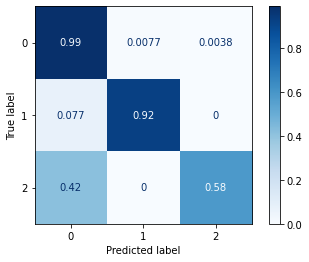

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = normalizeData(X, scaler='Standard', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

# param_grid = {
#             'min_child_weight': [1, 5, 10],
#             'gamma': [0.5, 1, 1.5, 2, 5],
#             'subsample': [0.6, 0.8, 1.0],
#             'colsample_bytree': [0.1, 0.25, 0.5, 0.75, 1.0],
#             'max_depth': [1, 2, 3, 4, 5],
#             'alpha': [5, 7.5, 10, 12.5]
#             }

param_grid = {
            'min_child_weight': [0.75],
            'gamma': [1/16],
            'subsample': [0.6],
            'colsample_bytree': [0.3],
            'max_depth': [4],
}

xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective='multi:softprob')

grid = GridSearchCV(xgb_cl, param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train, y_train)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 8.4.2. SMOTE

Scaling each feature by removing the mean and scaling to unit variance
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 612, 2: 612}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0625,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.75, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.3, 'gamma': 0.0625, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 0.6} None
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       261
         1.0       0.87      1.00      0.93        13
         2.0       0.71      0.83      0.77        12

    accuracy      

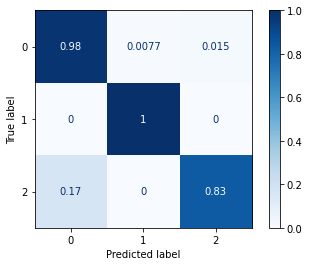

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = normalizeData(X, scaler='Standard', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

oversample = SMOTE(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = {
            'min_child_weight': [0.75],
            'gamma': [1/16],
            'subsample': [0.6],
            'colsample_bytree': [0.3],
            'max_depth': [4],
}

xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective='multi:softprob')

grid = GridSearchCV(xgb_cl, param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 8.4.3. Borderline SMOTE

Scaling each feature by removing the mean and scaling to unit variance
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 612, 2: 612}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0625,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.75, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.3, 'gamma': 0.0625, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 0.6} None
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       261
         1.0       0.86      0.92      0.89        13
         2.0       0.89      0.67      0.76        12

    accuracy      

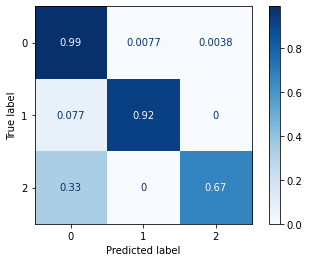

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = normalizeData(X, scaler='Standard', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

oversample = BorderlineSMOTE(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = {
            'min_child_weight': [0.75],
            'gamma': [1/16],
            'subsample': [0.6],
            'colsample_bytree': [0.3],
            'max_depth': [4],
}

xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective='multi:softprob')

grid = GridSearchCV(xgb_cl, param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 8.4.4. ADASYN

Scaling each feature by removing the mean and scaling to unit variance
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 613, 2: 619}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0625,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.75, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.3, 'gamma': 0.0625, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 0.6} None
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       261
         1.0       0.76      1.00      0.87        13
         2.0       0.57      0.67      0.62        12

    accuracy      

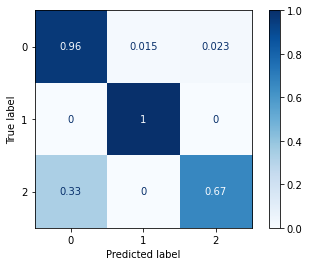

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = normalizeData(X, scaler='Standard', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

oversample = ADASYN(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = {
            'min_child_weight': [0.75],
            'gamma': [1/16],
            'subsample': [0.6],
            'colsample_bytree': [0.3],
            'max_depth': [4],
}

xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective='multi:softprob')

grid = GridSearchCV(xgb_cl, param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 8.4.5. SMOTEENN


Scaling each feature by removing the mean and scaling to unit variance
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 497, 1: 612, 2: 612}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0625,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.75, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.3, 'gamma': 0.0625, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 0.6} None
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       261
         1.0       0.72      1.00      0.84        13
         2.0       0.53      0.83      0.65        12

    accuracy      

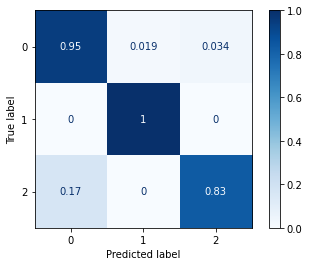

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = normalizeData(X, scaler='Standard', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

oversample = SMOTEENN(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = {
            'min_child_weight': [0.75],
            'gamma': [1/16],
            'subsample': [0.6],
            'colsample_bytree': [0.3],
            'max_depth': [4],
}

xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective='multi:softprob')

grid = GridSearchCV(xgb_cl, param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### 8.4.6. SMOTETomek

Scaling each feature by removing the mean and scaling to unit variance
Train dataset with:		 {0: 612, 1: 28, 2: 25}
OverSampled Train dataset with:	 {0: 612, 1: 612, 2: 612}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0625,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.75, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
{'colsample_bytree': 0.3, 'gamma': 0.0625, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 0.6} None
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       261
         1.0       0.87      1.00      0.93        13
         2.0       0.71      0.83      0.77        12

    accuracy      

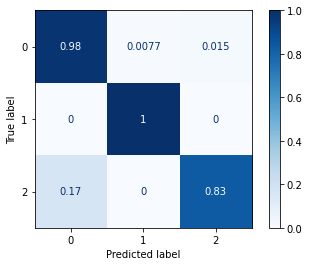

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = normalizeData(X, scaler='Standard', range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

oversample = SMOTETomek(random_state=12)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

unique, count = np.unique(y_train, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('Train dataset with:\t\t', y_train_dict_value_count)

unique, count = np.unique(y_train_OS, return_counts=True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique.astype(int), count)}
print('OverSampled Train dataset with:\t', y_train_dict_value_count)

param_grid = {
            'min_child_weight': [0.75],
            'gamma': [1/16],
            'subsample': [0.6],
            'colsample_bytree': [0.3],
            'max_depth': [4],
}

xgb_cl = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective='multi:softprob')

grid = GridSearchCV(xgb_cl, param_grid, cv=5, scoring='f1_macro')

grid.fit(X_train_OS, y_train_OS)

print(grid.best_params_, print(grid.best_estimator_))

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

disp = plot_confusion_matrix(grid, X_test, y_test,
                                 display_labels=[0, 1, 2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')